In [1]:
from sklearn.neighbors import NearestNeighbors
from labels import labels_11, labels_19
import numpy as np
import cv2
import os
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
def create_label_colormap(labels):
    colormap = {}
    for label in labels:
        colormap[label.id] = label.color
    return colormap

# Example usage with your 19-class labels
# Ensure labels.py is in the same directory or correctly referenced
colormap = create_label_colormap(labels_19)

def load_image(image_path):
    # Load image in grayscale mode (even though it's grayscale, OpenCV loads it as BGR)
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

## MEAN YAHYA

In [3]:
def fill_missing_depths(depth_map, segmentation_map, method='mean', 
                        min_component_size=1000, max_component_size=90000, 
                        neighbor_search_radius=5):
    """
    Fill missing depth values in connected components (of a specific size range) 
    within each class, using the mean/median of valid neighboring pixels 
    of the SAME CLASS around that component.

    Args:
        depth_map: 2D depth map with NaN for missing values (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)
        method: Filling method ('median' or 'mean') for local neighborhood.
        min_component_size: Min area of a missing component to fill.
        max_component_size: Max area of a missing component to fill.
        neighbor_search_radius: How many pixels out from the component boundary 
                                to look for valid neighbors. A radius of 1 means 
                                immediate 8-connected neighbors.
    
    Returns:
        Filled depth map (H, W)
    """
    filled_depth = depth_map.copy()
    unique_classes = np.unique(segmentation_map)
    height, width = depth_map.shape

    # print(f"Fill missing depths (method: {method}): Min component size: {min_component_size}, Max: {max_component_size}, Radius: {neighbor_search_radius}")

    for class_id in unique_classes:
        class_mask_original = (segmentation_map == class_id) # Mask for the entire class area
        
        # Identify missing pixels ONLY within the current class
        missing_pixels_in_class_mask = np.logical_and(class_mask_original, np.isnan(depth_map))
        
        if not np.any(missing_pixels_in_class_mask): # No missing pixels in this class
            # print(f"  Class {class_id}: No missing pixels to fill.")
            continue

        # Find connected components of missing pixels within this class
        # cv2.connectedComponentsWithStats requires uint8 input
        num_labels, labels_map, stats, _ = cv2.connectedComponentsWithStats(
            missing_pixels_in_class_mask.astype(np.uint8), 
            connectivity=8,  # Consider 8-connectivity
            ltype=cv2.CV_32S
        )
        
        # print(f"  Class {class_id}: Found {num_labels - 1} connected components of missing pixels.")
        filled_component_count = 0

        for label_idx in range(1, num_labels): # Label 0 is the background (non-missing pixels in this mask), so skip it
            component_area = stats[label_idx, cv2.CC_STAT_AREA]
            
            #if not (min_component_size <= component_area <= max_component_size):
                # print(f"    Component {label_idx} (Area: {component_area}): Skipped (size criteria not met).")
             #   continue # Skip components outside the desired size range

            current_component_mask = (labels_map == label_idx)

            # Find neighbors of this component
            # Dilate the component mask to find potential neighbors
            kernel_size = 2 * neighbor_search_radius + 1
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            # Ensure current_component_mask is uint8 for dilate
            dilated_component_mask_uint8 = cv2.dilate(current_component_mask.astype(np.uint8), kernel, iterations=1)
            dilated_component_mask = dilated_component_mask_uint8.astype(bool)
            
            # Neighbor mask excludes the component itself
            neighbor_mask_boundary = np.logical_and(dilated_component_mask, ~current_component_mask)
            
            # Consider only neighbors that are:
            # 1. Within the image bounds (implicitly handled by array indexing)
            # 2. Part of the SAME class_id (using class_mask_original)
            # 3. Have VALID depth values (not NaN in the original depth_map)
            valid_neighbors_in_same_class_mask = np.logical_and.reduce((
                neighbor_mask_boundary,
                class_mask_original,    # Ensures neighbors are of the same class
                ~np.isnan(depth_map) # Ensures neighbors have valid depth in original map
            ))

            valid_neighbor_depths = depth_map[valid_neighbors_in_same_class_mask]

            if len(valid_neighbor_depths) > 0:
                if method == 'median':
                    fill_value = np.median(valid_neighbor_depths)
                elif method == 'mean':
                    fill_value = np.mean(valid_neighbor_depths)
                else: # Default to median for any other method string passed
                    # print(f"    Component {label_idx}: Unknown method '{method}'. Defaulting to local median.")
                    fill_value = np.median(valid_neighbor_depths)
                
                # Fill all pixels in this component with the calculated local fill_value
                filled_depth[current_component_mask] = fill_value
                filled_component_count +=1
                # print(f"    Component {label_idx} (Area: {component_area}): Filled with {fill_value:.4f} from {len(valid_neighbor_depths)} neighbors.")
            # else:
                # print(f"    Component {label_idx} (Area: {component_area}): No valid same-class neighbors found. Remains NaN.")
                
        # if filled_component_count > 0:
            # print(f"  Class {class_id}: Filled {filled_component_count} components matching size criteria using local stats.")
            
    return filled_depth

## KNN ANASS

In [4]:
#from google.colab.patches import cv2_imshow
def densify_depth_map_using_knn(depth_map, segmented_image, k_neighbors=5):
    output_depth_map = np.copy(depth_map).astype(np.float32)

    # Obtenir les labels uniques dans l'image segmentée
    unique_labels = np.unique(segmented_image)
    for label in unique_labels:
        # Créer un masque pour le segment actuel
        mask = segmented_image == label

        # Identifiez les pixels valides et invalides
        valid_mask = (depth_map > 0) & mask
        invalid_mask = (depth_map == 0) & mask

        # Obtenez les coordonnées et valeurs de profondeur des pixels valides
        valid_coords = np.column_stack(np.where(valid_mask))
        valid_depths = depth_map[valid_mask]

        # Obtenez les coordonnées des pixels invalides
        invalid_coords = np.column_stack(np.where(invalid_mask))

        #print(f"Segment {label}: {valid_coords.shape[0]} valid points, {invalid_coords.shape[0]} invalid points")

        # Vérifier s'il y a des pixels valides et invalides avant d'utiliser kNN
        if valid_coords.shape[0] == 0:
            #Avertissement : Aucun point valide pour le segment {label}, segment ignoré
            continue  # Ignorer ce segment

        if invalid_coords.shape[0] == 0:
            #Aucun pixel à interpoler pour le segment {label}, passage au suivant
            continue  # Ignorer ce segment

        # Construisez le modèle kNN pour les pixels valides
        knn = NearestNeighbors(n_neighbors=min(k_neighbors, valid_coords.shape[0]))  # Sécuriser le nombre de voisins
        knn.fit(valid_coords)

        # Trouvez les k plus proches voisins pour chaque pixel invalide
        distances, indices = knn.kneighbors(invalid_coords)

        # Interpoler les profondeurs pour les pixels invalides
        for i, point in enumerate(invalid_coords):
            neighbor_depths = valid_depths[indices[i]]  # Profondeurs des k voisins
            output_depth_map[point[0], point[1]] = np.mean(neighbor_depths)  # Moyenne des profondeurs

    return output_depth_map


## KNN yahya

In [5]:
from sklearn.neighbors import KNeighborsRegressor 
def knn_fill_missing_depths(depth_map, segmentation_map, k=5):
    """
    Fill missing depth values using K-Nearest Neighbors (KNN) based on segmentation classes.
    Uses sklearn.neighbors.KNeighborsRegressor for efficiency.

    Args:
        depth_map: 2D depth map with NaN for missing values (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)
        k: Number of nearest neighbors to consider

    Returns:
        Filled depth map (H, W)
    """
    filled_depth = depth_map.copy()
    height, width = depth_map.shape

    # Identify valid (non-NaN) pixels to use for training KNN regressors
    valid_mask = (depth_map != 0)
    valid_positions_all = np.array(np.where(valid_mask)).T  # Shape: (n_valid, 2)
    valid_depths_all = depth_map[valid_mask]               # Shape: (n_valid,)

    # Identify missing pixels that need filling
    missing_mask = (depth_map == 0)
    missing_positions = np.array(np.where(missing_mask)).T # Shape: (n_missing, 2)

    if len(valid_positions_all) == 0:
        print("KNN Warning: No valid pixels found in the depth map. Returning original depth map.")
        return filled_depth  # No valid data to learn from, return as is (all NaNs)
    if len(missing_positions) == 0:
        print("KNN Info: No missing pixels to fill.")
        return filled_depth # No missing data to fill

    # Create regressors for each class that has at least one valid data point
    regressors_by_class = {}
    unique_classes_with_valid_data = np.unique(segmentation_map[valid_mask])

    for class_id in unique_classes_with_valid_data:
        # Get valid positions and depths for the current class
        class_points_mask_on_valid = (segmentation_map[valid_mask] == class_id)
        current_class_positions = valid_positions_all[class_points_mask_on_valid]
        current_class_depths = valid_depths_all[class_points_mask_on_valid]

        if len(current_class_positions) >=5:        # Arbitrary threshold for KNN training
            # KNeighborsRegressor automatical-ly uses min(k, n_samples_fit) for n_neighbors
            # However, n_neighbors must be > 0 for fit.
            actual_k_class = min(k, len(current_class_positions))
            actual_k_class = k # added for testing purposes
            if actual_k_class == 0: # Should not happen if len(current_class_positions) > 0
                actual_k_class = 1 
            
            knn = KNeighborsRegressor(n_neighbors=actual_k_class, weights='uniform',)
            knn.fit(current_class_positions, current_class_depths)
            regressors_by_class[class_id] = knn

    # Create a fallback regressor using all valid data points
    knn_fallback = None
    
    actual_k_fallback = min(k, len(valid_positions_all))
    if actual_k_fallback > 0:
        knn_fallback = KNeighborsRegressor(n_neighbors=actual_k_fallback, weights='uniform')
        knn_fallback.fit(valid_positions_all, valid_depths_all)
    
    # Iterate through missing positions and fill them
    # Batch predictions for efficiency if many missing pixels share the same class
    
    unique_classes_in_missing = np.unique(segmentation_map[missing_mask])
    
    for class_id_of_missing in unique_classes_in_missing:
        # Get all missing positions for the current class_id
        current_class_missing_mask_on_original = np.logical_and(missing_mask, segmentation_map == class_id_of_missing)
        positions_to_predict_for_class = np.array(np.where(current_class_missing_mask_on_original)).T
        
        if len(positions_to_predict_for_class) == 0:
            continue

        regressor = regressors_by_class.get(class_id_of_missing)
        
        if regressor:
            # Use the regressor specific to this class if available
            predicted_depths = regressor.predict(positions_to_predict_for_class)
            for idx, (r, c) in enumerate(positions_to_predict_for_class):
                filled_depth[r, c] = predicted_depths[idx]
        elif knn_fallback:
            # Fallback: class_id_of_missing had no valid data points.
            # Use the regressor trained on all valid points.
            predicted_depths = knn_fallback.predict(positions_to_predict_for_class)
            for idx, (r, c) in enumerate(positions_to_predict_for_class):
                filled_depth[r, c] = predicted_depths[idx]
        else:
            # This case is hit if len(valid_positions_all) == 0 or k=0 for fallback
            # which should be handled at the start.
            # If somehow reached, leave as NaN or use a global default.
            # For now, we'll leave them as NaN, as there's no basis for prediction.
            pass # filled_depth for these positions remains NaN

    return filled_depth


## HDBSCAN ANASS

In [6]:
from sklearn.neighbors import KDTree
from hdbscan import HDBSCAN
def densify_depth_map_using_hdbscan(depth_map, segmented_image):
    output_depth_map = np.copy(depth_map).astype(np.float32)

    # Process each unique segment label
    unique_labels = np.unique(segmented_image)
    for label in unique_labels:
        # Create mask for current segment
        mask = segmented_image == label
        segment_depths = depth_map[mask]

        # Mask to identify valid depths
        valid_mask = segment_depths > 0
        if np.any(valid_mask):
            # Get coordinates of valid and invalid depth pixels
            valid_depths = segment_depths[valid_mask]
            valid_coords = np.column_stack(np.where(mask & (depth_map > 0)))
            invalid_coords = np.column_stack(np.where(mask & (depth_map == 0)))

            # Clustering valid depth coordinates using HDBSCAN
            if valid_coords.shape[0] >= 10:  # Ensure there are enough points to form a cluster
                clusterer = HDBSCAN(min_samples=15, min_cluster_size=5) #Effectue un clustering HDBSCAN sur les pixels valides pour détecter des clusters cohérents.
                labels = clusterer.fit_predict(valid_coords)

                # Filter out noise
                core_samples_mask = labels != -1
                if np.any(core_samples_mask):
                    core_coords = valid_coords[core_samples_mask]
                    core_depths = valid_depths[core_samples_mask]

                    # Create a KDTree for the core points
                    if core_coords.shape[0] > 1:  # Ensure there are at least two points to form a KDTree
                        tree = KDTree(core_coords)

                        # Assign depth values to invalid coordinates using nearest neighbor in KDTree
                        # Utilise un arbre KDTree pour associer rapidement les pixels manquants à leurs voisins les plus proches parmi les clusters.
                        for point in invalid_coords:
                            if tree.valid_metrics:
                                dist, ind = tree.query([point], k=1)
                                output_depth_map[tuple(point)] = core_depths[ind[0]]

    return output_depth_map

## HDBSCAN YAHYA

In [7]:
import hdbscan
def hdbscan_fill_missing_depths(depth_map, segmentation_map, min_cluster_size=10):
    """
    Fill missing depth values using HDBSCAN clustering within each segmentation class.
    
    Args:
        depth_map: 2D depth map with NaN for missing values (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)
        min_cluster_size: Minimum cluster size for HDBSCAN
    
    Returns:
        Filled depth map (H, W)
    """
    filled_depth = depth_map.copy()
    height, width = depth_map.shape
    unique_classes = np.unique(segmentation_map)
    
    for class_id in unique_classes:
        class_mask = (segmentation_map == class_id)
        valid_mask = np.logical_and(class_mask,depth_map != 0)
        missing_mask = np.logical_and(class_mask,depth_map ==0)
        
        if np.sum(valid_mask) < min_cluster_size:
            # Not enough points for clustering, fallback to mean
            fill_value = np.nanmean(depth_map[valid_mask]) if np.sum(valid_mask) > 0 else 0
            filled_depth[missing_mask] = fill_value
            continue
        
        # Prepare data for clustering
        valid_indices = np.array(np.where(valid_mask)).T
        valid_depths = depth_map[valid_mask]
        
        # Cluster valid points
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        labels = clusterer.fit_predict(valid_indices)
        
        # Compute mean depth for each cluster
        cluster_means = {}
        for lbl in np.unique(labels):
            if lbl == -1:
                continue  # Ignore noise
            cluster_means[lbl] = np.mean(valid_depths[labels == lbl])
        
        # Fill missing pixels by nearest cluster mean
        missing_indices = np.array(np.where(missing_mask)).T
        if len(missing_indices) == 0 or len(cluster_means) == 0:
            continue
        
        cluster_centers = np.array([valid_indices[labels == lbl].mean(axis=0) for lbl in cluster_means.keys()])
        cluster_labels = list(cluster_means.keys())
        
        for idx, (i, j) in enumerate(missing_indices):
            # Find nearest cluster center
            dists = np.linalg.norm(cluster_centers - np.array([i, j]), axis=1)
            nearest = np.argmin(dists)
            fill_value = cluster_means[cluster_labels[nearest]]
            filled_depth[i, j] = fill_value
    
    return filled_depth

## KMEANS ANASS

In [8]:
def densify_depth_map_using_kmeans(depth_map, segmented_image, n_clusters):
    output_depth_map = np.copy(depth_map).astype(np.float32)

    # Traiter chaque segment
    unique_labels = np.unique(segmented_image)
    for label in unique_labels:
        mask = (segmented_image == label)  # Masque pour le segment actuel
        segment_depths = depth_map[mask]  # Profondeurs associées au segment

        # Trouver les profondeurs valides
        valid_mask = segment_depths > 0
        if np.any(valid_mask):
            valid_depths = segment_depths[valid_mask]
            valid_coords = np.column_stack(np.where(mask & (depth_map > 0)))  # Coordonnées des pixels valides
            invalid_coords = np.column_stack(np.where(mask & (depth_map == 0)))  # Coordonnées des pixels manquants

            # Appliquer K-Means sur les coordonnées valides
            if valid_coords.shape[0] >= n_clusters:  # S'assurer d'avoir assez de points
                kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
                kmeans.fit(valid_coords)

                # Calculer les centres des clusters
                cluster_centers = kmeans.cluster_centers_
                cluster_labels = kmeans.labels_

                # Pour chaque pixel manquant, trouver le cluster le plus proche et Associe chaque pixel invalide au cluster le plus proche.
                for point in invalid_coords:
                    distances = np.linalg.norm(cluster_centers - point, axis=1)
                    nearest_cluster = np.argmin(distances)
                    nearest_label = cluster_labels == nearest_cluster
                    nearest_depth = np.mean(valid_depths[nearest_label])  # Profondeur moyenne du cluster
                    output_depth_map[tuple(point)] = nearest_depth

    return output_depth_map

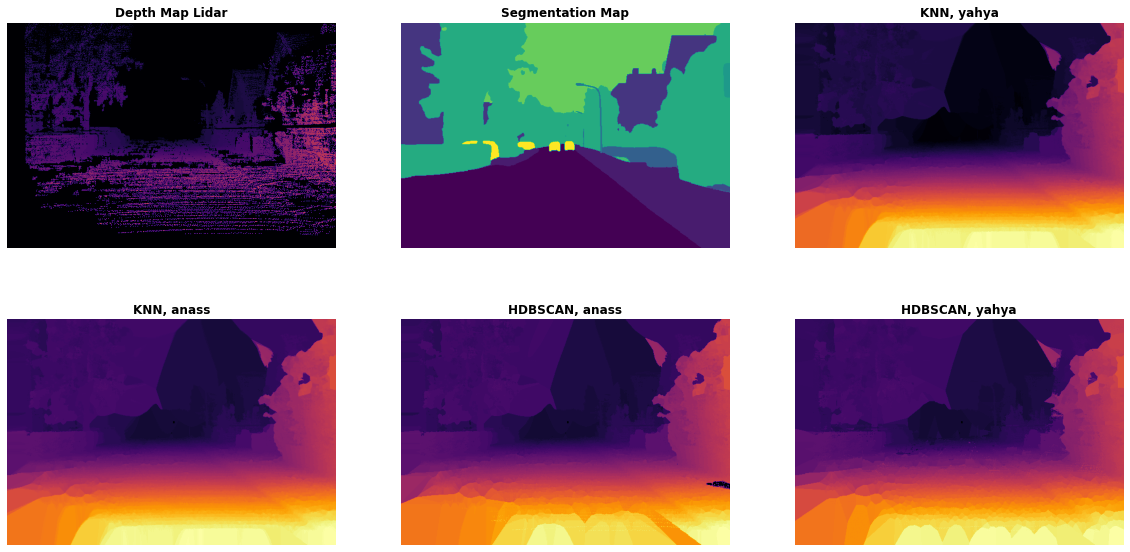

In [9]:
image_path = './train/zurich_city_01_a/19classes/000074.png'
disparity_path = './zurich_city_01_a_disparity_event/000074.png'

# Load images in grayscale
label_image = load_image(image_path)  # shape: (H, W)
disparity_map = load_image(disparity_path)  # shape: (H, W)

# Resize both images to (480, 640) (width, height order for OpenCV)
label_image = cv2.resize(label_image, (640, 480), interpolation=cv2.INTER_NEAREST)
disparity_map = cv2.resize(disparity_map, (640, 480), interpolation=cv2.INTER_NEAREST)

# Convert disparity to float and scale
disp = disparity_map.astype(float) / 256.0  # shape: (480, 640)

# Use only the top 440 rows for all processing
disp_crop = disp[:440, :]
label_crop = label_image[:440, :]

densified_mean_yahya = fill_missing_depths(
    disp_crop * 255, label_crop, method='mean',
    min_component_size=10, max_component_size=100, neighbor_search_radius=5)

densified_knn_yahya = knn_fill_missing_depths(disp_crop * 255, label_crop, 2)
densified_knn_anass = densify_depth_map_using_knn(disp_crop * 255, label_crop, 2)

densified_hdbscan_anass = densify_depth_map_using_hdbscan(disp_crop * 255, label_crop)
densified_hdbscan_yahya = hdbscan_fill_missing_depths(disp_crop * 255, label_crop, 2)

# Optional: KMeans
# densified_kmeans = densify_depth_map_using_kmeans(disp_crop * 255, label_crop, 2)

# Visualization (optional)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

axs[0, 0].imshow(disp_crop * 255, cmap='inferno')
axs[0, 0].set_title('Depth Map Lidar', fontweight='bold')
axs[0, 0].axis('off')

axs[0, 1].imshow(label_crop)
axs[0, 1].set_title('Segmentation Map', fontweight='bold')
axs[0, 1].axis('off')

# axs[0, 2].imshow(densified_mean_yahya, cmap='inferno')
# axs[0, 2].set_title('Depth Map Lidar+Seg+Mean, yahya', fontweight='bold')
# axs[0, 2].axis('off')

axs[0, 2].imshow(densified_knn_yahya, cmap='inferno')
axs[0, 2].set_title('KNN, yahya', fontweight='bold')
axs[0, 2].axis('off')

axs[1, 0].imshow(densified_knn_anass, cmap='inferno')
axs[1, 0].set_title('KNN, anass', fontweight='bold')
axs[1, 0].axis('off')

axs[1, 1].imshow(densified_hdbscan_anass, cmap='inferno')
axs[1, 1].set_title('HDBSCAN, anass', fontweight='bold')
axs[1, 1].axis('off')

axs[1, 2].imshow(densified_hdbscan_yahya, cmap='inferno')
axs[1, 2].set_title('HDBSCAN, yahya', fontweight='bold')
axs[1, 2].axis('off')

plt.show()